2024-11-24 19:34:26.647237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 19:34:27.437721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 19:34:29.040773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - loss: 0.6349 - learning_rate: 0.0010


/home/mili/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mili/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


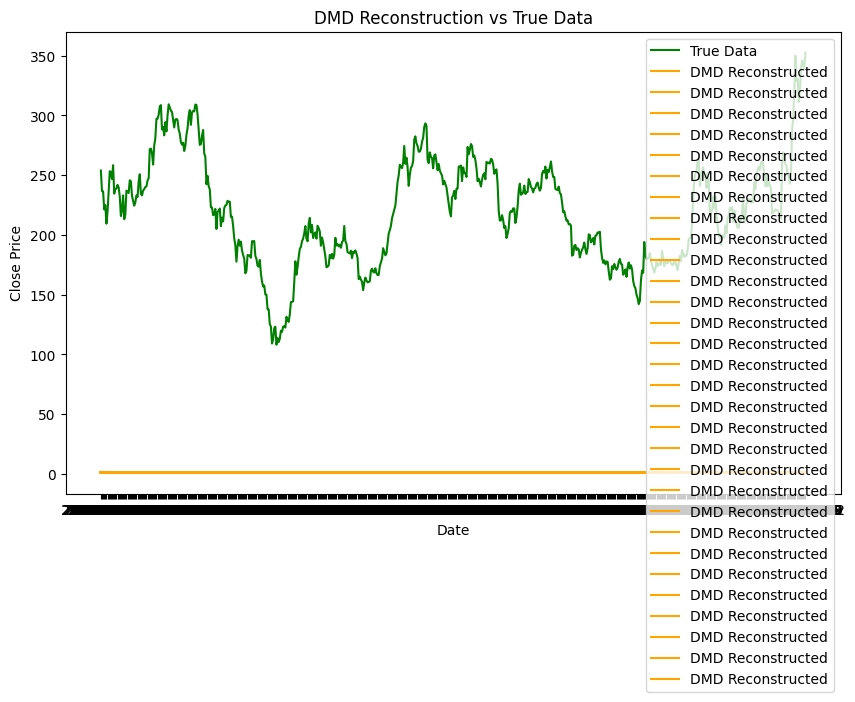

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau   

# Function to create a Hankel matrix
def create_hankel_matrix(data, rows):
    cols = len(data) - rows + 1
    hankel_matrix = np.array([data[i:i+rows] for i in range(cols)])
    return hankel_matrix.T

# Function to perform Dynamic Mode Decomposition (DMD)
def perform_dmd(X, rank):
    X1 = X[:, :-1]  # Exclude the last column
    X2 = X[:, 1:]   # Exclude the first column
    
    # Compute SVD
    U, S, Vh = np.linalg.svd(X1, full_matrices=False)
    
    # Truncate to the specified rank
    U = U[:, :rank]
    S = np.diag(S[:rank])
    Vh = Vh[:rank, :]
    
    # Compute A_tilde
    A_tilde = U.T @ X2 @ Vh.T @ np.linalg.inv(S)
    eigvals, eigvecs = np.linalg.eig(A_tilde)
    
    # Compute DMD modes
    Phi = X2 @ Vh.T @ np.linalg.inv(S) @ eigvecs
    
    return eigvals, Phi


# Function to reconstruct signal using DMD
def reconstruct_signal_dmd(X, eigvals, Phi, timesteps):
    b = np.linalg.lstsq(Phi, X[:, 0], rcond=None)[0]
    time_dynamics = np.array([b * (eigvals ** t) for t in range(timesteps)])
    return Phi @ time_dynamics.T

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset
def split_data(df, training_period, train_ratio=0.8):
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()

    # Split data
    split_idx = int(len(df) * train_ratio)
    train_data = scaled_data.iloc[:split_idx]
    test_data = scaled_data.iloc[split_idx:]

    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']

    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# LSTM training function
def train_lstm(X_train, y_train, input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

    lr_scheduler = ReduceLROnPlateau(
        monitor='loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6
    )

    model.fit(X_train, y_train.values, epochs=1, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    return model
def evaluate_predictions_dmd(model, X_test, y_test, test_index, n_days_to_predict, feature_scaler, target_scaler):
    hankel_window = 30
    X_test_hankel = create_hankel_matrix(y_test.values, hankel_window)
    
    eigvals, Phi = perform_dmd(X_test_hankel, rank=10)
    reconstructed = reconstruct_signal_dmd(X_test_hankel, eigvals, Phi, len(y_test))

    # Plot results
    plt.figure(figsize=(10, 6))
    y_true_unscaled = target_scaler.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
    plt.plot(test_index, y_true_unscaled, label="True Data", color="green")
    plt.plot(test_index[:len(reconstructed.T)], reconstructed.T[:len(y_test)], label="DMD Reconstructed", color="orange")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("DMD Reconstruction vs True Data")
    plt.legend()
    plt.show()

# Main
training_period = 30
path = "../yfinance/TSLA.csv"
headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

df = pd.read_csv(path, names=headers, skiprows=1)
df.replace("null", np.nan, inplace=True)
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
df.set_index("Date", inplace=True)

X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period)
input_shape = (X_train.shape[1], 1)
model = train_lstm(X_train, y_train, input_shape)

evaluate_predictions_dmd(model, X_test, y_test, test_index, 30, feature_scaler, target_scaler)


In [4]:

training_period = 30
path = "../yfinance/TSLA.csv"
headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

df = pd.read_csv(path, names=headers, skiprows=1)
df.replace("null", np.nan, inplace=True)
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
df.set_index("Date", inplace=True)

X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Helper: Create Hankel Matrix
def create_hankel_matrix(data, window_size):
    rows = len(data) - window_size + 1
    hankel_matrix = np.zeros((window_size, rows))
    for i in range(window_size):
        hankel_matrix[i] = data[i:i + rows]
    return hankel_matrix

# Perform DMD
def perform_dmd(X, rank):
    U, S, Vh = np.linalg.svd(X[:, :-1], full_matrices=False)
    U = U[:, :rank]
    S = np.diag(S[:rank])
    Vh = Vh[:rank, :]
    
    A_tilde = U.T @ X[:, 1:] @ Vh.T @ np.linalg.inv(S)
    eigvals, eigvecs = np.linalg.eig(A_tilde)
    Phi = X[:, 1:] @ Vh.T @ np.linalg.inv(S) @ eigvecs
    return eigvals, Phi

# Reconstruct Signal
def reconstruct_signal_dmd(X, eigvals, Phi, steps):
    b = np.linalg.lstsq(Phi, X[:, 0], rcond=None)[0]
    time_dynamics = np.zeros((len(eigvals), steps), dtype=complex)
    for i, eig in enumerate(eigvals):
        time_dynamics[i, :] = b[i] * (eig ** np.arange(steps))
    return (Phi @ time_dynamics).real

# Debugging and Fixes
def evaluate_dmd(y_test, hankel_window, rank):
    # Normalize Data
    scaler = MinMaxScaler()
    y_test_scaled = scaler.fit_transform(y_test.reshape(-1, 1)).flatten()
    
    # Create Hankel Matrix
    X_test_hankel = create_hankel_matrix(y_test_scaled, hankel_window)
    
    # Perform DMD
    eigvals, Phi = perform_dmd(X_test_hankel, rank)
    
    # Print and Plot Eigenvalues
    print("Eigenvalues:", eigvals)
    plt.figure()
    plt.scatter(eigvals.real, eigvals.imag, color='red')
    plt.title("DMD Eigenvalues")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid()
    plt.show()
    
    # Reconstruct Signal
    reconstructed = reconstruct_signal_dmd(X_test_hankel, eigvals, Phi, X_test_hankel.shape[1])
    
    # Plot Original vs Reconstructed
    plt.figure()
    plt.plot(y_test_scaled[:45], label='Original', linestyle='dashed')
    plt.plot(reconstructed[0][:45], label='Reconstructed')
    plt.title("Original vs Reconstructed Signal")
    plt.legend()
    plt.show()

# Example Usage
hankel_window = 40
rank = 1000

# Simulated or real test data
print(y_test)
y_test = np.array(y_test)
# y_test = np.sin(np.linspace(0, 10, 300))  # Replace with actual data
evaluate_dmd(y_test, hankel_window, rank)


[1.52467246 1.36368519 1.36247308 1.22100323 1.25518963 1.10992824
 1.20515316 1.35722087 1.51851899 1.5142611  1.45866143 1.56628688
 1.34422993 1.37931773 1.38497412 1.41275837 1.39261938 1.32290999
 1.16913294 1.21718052 1.3300892  1.14454983 1.17867406 1.36772542
 1.35886804 1.34938909 1.44856092 1.44122636 1.32695022 1.28803986
 1.25059001 1.2766029  1.33071076 1.31827935 1.43771451 1.49570724
 1.34261393 1.33074191 1.36775643 1.37962859 1.39597588 1.40045117
 1.44691376 1.46528124 1.69097424 1.69597804 1.6604549  1.57119707
 1.72000176 1.77668906 1.92819738 1.92937848 1.96023954 2.02373316
 2.0352633  1.84447173 1.86548082 1.79937661 1.90215347 1.83011333
 1.95504936 2.04166559 2.0159634  1.99203301 1.98152832 1.92369094
 1.8607257  1.92170205 1.9277003  1.91812803 1.84372569 1.81323765
 1.74685374 1.72736719 1.74181893 1.67701987 1.71627238 1.80279528
 1.85463441 1.95178605 1.99598006 1.88139307 1.9791041  1.98973313
 1.98600375 2.03933469 2.0361647  1.96222843 1.84838748 1.7247

KeyboardInterrupt: 